## Project Overview: 
In this project, I'm trying to follow a generalised approach to dealing with imbalanced datasets. This dataset essentially contains transactions that are classified as fraud and non fraud. But the number of fraud transactions are really low (<1%) in the dataset. This is a perfect example of imbalanced data in the real world setting.

Approach taken:
- First made sure not to sample the data before the train test split. This ensures that we are testing on the original test data set and not on the synthesized oversampled data or lossy data from undersampling.
- After spliting the data, tried both undersampling the data and oversampling the traind data.
- After having done both undersampling and oversampling of training data, cross validated to evaluate the performance after training a Logistic Regression, KNN, SVC, and DecisionTree models.
- Tried the approach of oversampling the data during cross validation and not before for a more accurate model.
- Fed the sampled training data to neural net to evaluate performance. 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-08 04:01:10.246045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 04:01:10.246196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 04:01:10.406308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results__.html
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__notebook__.ipynb
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__output__.json
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/custom.css
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___72_1.png
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___41_1.png
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___61_0.png
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___25_0.png
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___10_0.png
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___51_1.png
/kaggle/input/credit-fraud-dealing-with-imbalanced-datasets/__results___files/__results___79_1.png
/kag

## Data Exploration and Pre-processing 

In [2]:
df = pd.read_csv('/kaggle/input/creditcard/creditcard.csv')

In [3]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


All features except Time and Amount are already scaled. We have no idea of what the columns V1-V28 mean. Class is the target variable with 0 being non-fraudulent and 1 being fraudulent cases. 

In [4]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='Amount'>

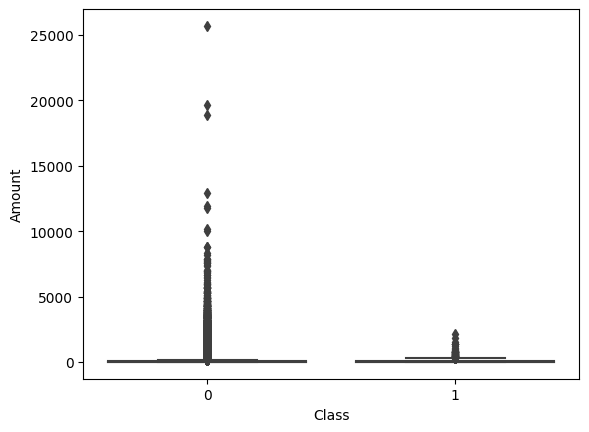

In [5]:
sns.boxplot(x = df['Class'], y = df['Amount'])

<Axes: xlabel='Class', ylabel='count'>

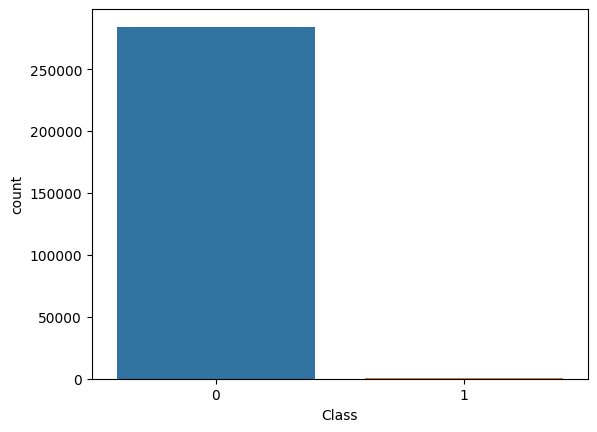

In [6]:
sns.countplot(x = df['Class'], data = df)

In [7]:
fraudCases = df['Class'].value_counts()[1]/len(df['Class']) * 100
nonfraudCases = df['Class'].value_counts()[0]/len(df['Class']) * 100
print(f'Fraud cases pct {fraudCases} and Non-Fraud cases pct {nonfraudCases}')

Fraud cases pct 0.1727485630620034 and Non-Fraud cases pct 99.82725143693798


Highly imbalanced dataset with 99.8% cases being normal transactions. If we use this data as such to train our model, it is very higly likely that the model will predict most transactions to be non-fradulent which will lead to a lot of mispredictions.
To avoid this we will have to make sure that the instances of both classes - fraudulent and non-fraudulent have to be the same. We do this either by undersampling or oversampling.
Undersampling involves reducing the number/ taking a subset of samples of the majority class. Oversampling involves synthesizing the minority class data using sampling libraries. 

<Axes: xlabel='Class', ylabel='Time'>

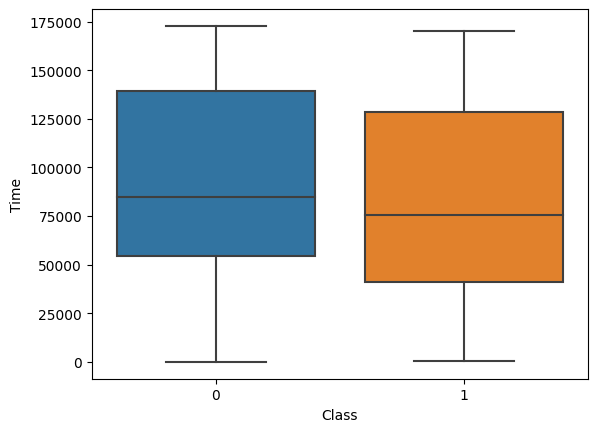

In [8]:
sns.boxplot(x = df['Class'], y = df['Time'])

Lets see the distribution of time and amount

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Time', ylabel='Count'>

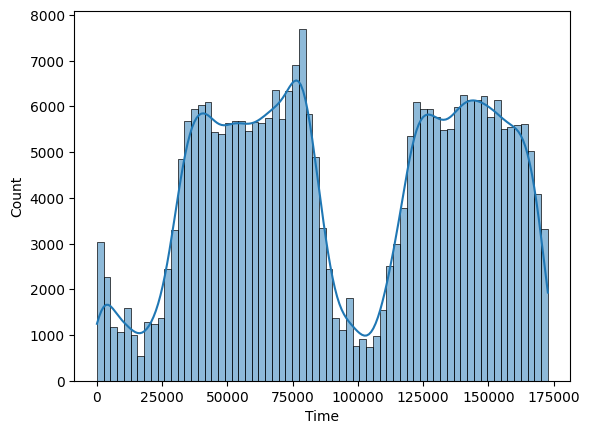

In [9]:
sns.histplot(data = df, x = 'Time', kde = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Amount', ylabel='Count'>

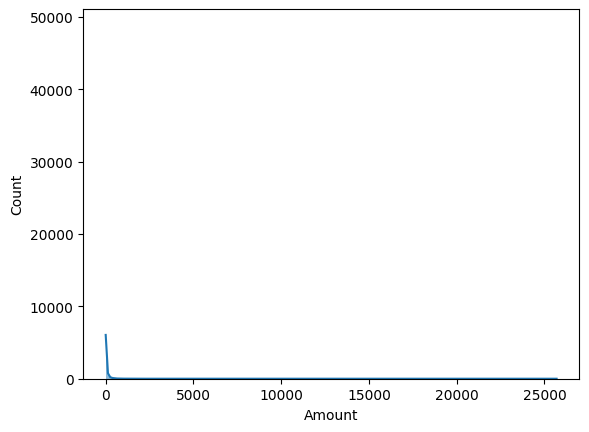

In [10]:
sns.histplot(data = df, x = 'Amount', kde = True)

In [11]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [12]:
df.drop(['Time', 'Amount'], axis = 1, inplace = True)

I will be undersampling the data considering there's only 0.17% of fraudulent transactions. Before doing so, the data needs to be split into train and test data. We do so because we need to test on our original dataframe and not on the data created by sampling methods.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [14]:
X = df.drop('Class', axis = 1)
y = df['Class']

sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False) # returns the index of 

In [15]:
#This our original dataframe on which the final testing will be done. 
#Using the stratiefied fold k spitting, we have retained the class distribution
for train_index, test_index in sss.split(X,y):
    original_X_Train,original_X_Test = X.iloc[train_index], X.iloc[test_index]
    original_y_Train,original_y_Test = y.iloc[train_index], y.iloc[test_index]
    
#We will check for the distribution of labels in train and test data. They should have similar distribution

train_labels, train_label_counts = np.unique(original_y_Train, return_counts = True)
test_labels, test_label_counts = np.unique(original_y_Test, return_counts = True)

print('Train label counts: ', train_label_counts/len(original_y_Train))
print('Test label counts: ', test_label_counts/len(original_y_Test))

Train label counts:  [0.99827076 0.00172924]
Test label counts:  [0.99827952 0.00172048]


We can see that the original distribution of the data is maintained after stratified k fold splitting.

In the following step, we perform random undersampling. We do this by making the number of both classes the same. The risk with this is loss of information.

In [16]:
shuffled_data = df.sample(frac=1.0, random_state=42) #shuffling before undersampling

fraud_cases = df.loc[df['Class'] == 1]
non_fraud_cases = df.loc[df['Class'] == 0][:len(fraud_cases)] 

print(f'No of fraud cases {len(fraud_cases)} and non-fraud cases {len(non_fraud_cases)}')

No of fraud cases 492 and non-fraud cases 492


In [17]:
equal_distributed_data = pd.concat([fraud_cases,non_fraud_cases])

new_df = equal_distributed_data.sample(frac = 1, random_state=42)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
121,-0.427191,0.745708,1.761811,-0.165130,0.058298,-0.213413,0.647323,0.073464,-0.291864,0.064800,...,-0.432070,0.013164,0.161606,-0.401310,0.047423,0.102549,-0.116571,0,-0.316767,-1.994962
248296,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,...,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1,-0.353229,1.243705
239,1.171439,0.474974,0.011761,1.264303,0.116234,-0.865986,0.554393,-0.276375,-0.471302,0.029104,...,0.278843,-0.097491,0.426278,0.744938,-0.274728,0.008472,0.015492,0,-0.273268,-1.993214
239501,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,...,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1,0.595357,1.165033
143336,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,-8.537758,...,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,1,0.657967,-0.200658


We now have equally distributed data. We can now go ahead with data analysis

<Axes: xlabel='Class', ylabel='count'>

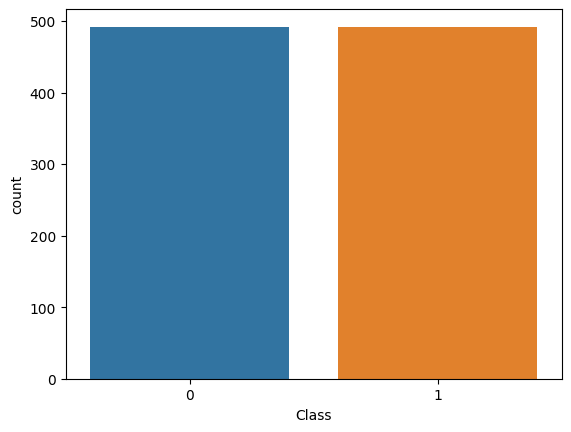

In [18]:
sns.countplot(x = 'Class', data = new_df)

Lets look at the correlation matrix since we now have a balanced class

<Axes: >

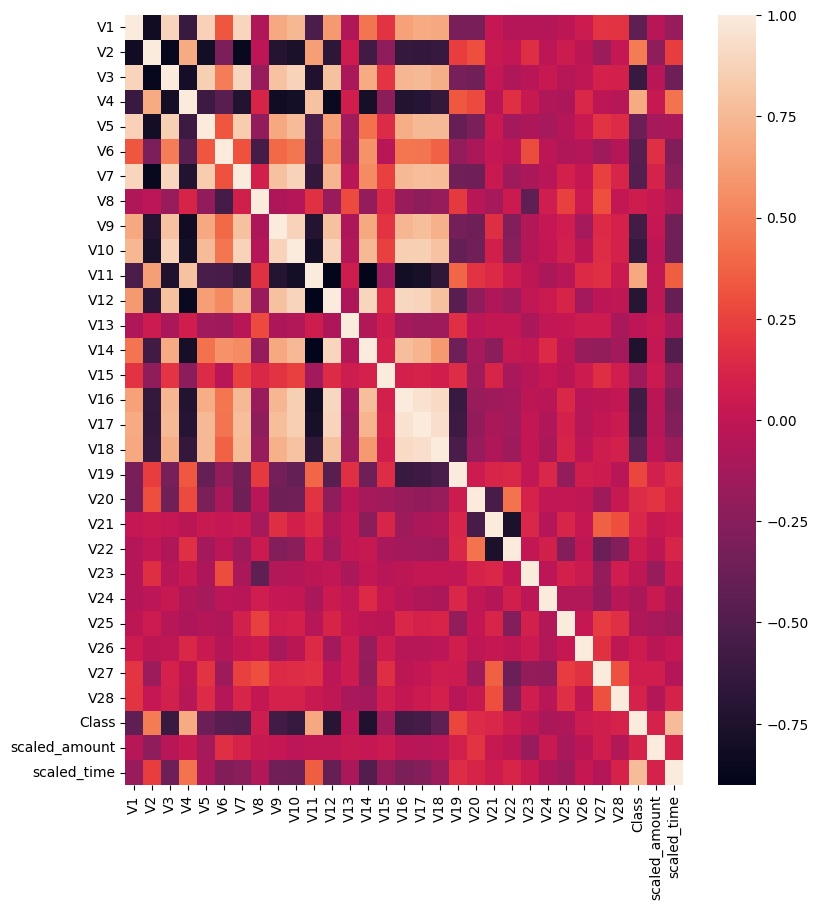

In [19]:
corr = new_df.corr()
plt.figure(figsize = (9,10))
sns.heatmap(corr)

In [20]:
print(corr['Class'])

V1              -0.426422
V2               0.478113
V3              -0.613963
V4               0.685672
V5              -0.378402
V6              -0.457721
V7              -0.484249
V8               0.063857
V9              -0.564955
V10             -0.631532
V11              0.675408
V12             -0.701195
V13             -0.018859
V14             -0.739062
V15             -0.155419
V16             -0.579323
V17             -0.554530
V18             -0.435873
V19              0.268535
V20              0.151902
V21              0.128754
V22              0.051141
V23             -0.003291
V24             -0.098485
V25             -0.072055
V26              0.054539
V27              0.074154
V28              0.107971
Class            1.000000
scaled_amount    0.108269
scaled_time      0.766175
Name: Class, dtype: float64


In [21]:
corr['Class'].sort_values(ascending = False)

Class            1.000000
scaled_time      0.766175
V4               0.685672
V11              0.675408
V2               0.478113
V19              0.268535
V20              0.151902
V21              0.128754
scaled_amount    0.108269
V28              0.107971
V27              0.074154
V8               0.063857
V26              0.054539
V22              0.051141
V23             -0.003291
V13             -0.018859
V25             -0.072055
V24             -0.098485
V15             -0.155419
V5              -0.378402
V1              -0.426422
V18             -0.435873
V6              -0.457721
V7              -0.484249
V17             -0.554530
V9              -0.564955
V16             -0.579323
V3              -0.613963
V10             -0.631532
V12             -0.701195
V14             -0.739062
Name: Class, dtype: float64

Positive Correlation: V2, V4, V11 and V19 are positively correlated.

Negative Correlation: V1, V3, V10, V12, V14, V16, V17, V18, V5, V6, V7, V9 are negatively correlated.

These features are helpful in informing us if the transaction is a fraud one pr not.Let's look at the boxplot of these features.

In [22]:
#neg_corr = ['V1', 'V3', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18', 'V5', 'V6', 'V7', 'V9']
neg_corr = ['V14', 'V12', 'V10', 'V3', 'V16', 'V9', 'V17']
pos_corr = ['V2', 'V4', 'V11', 'V19']

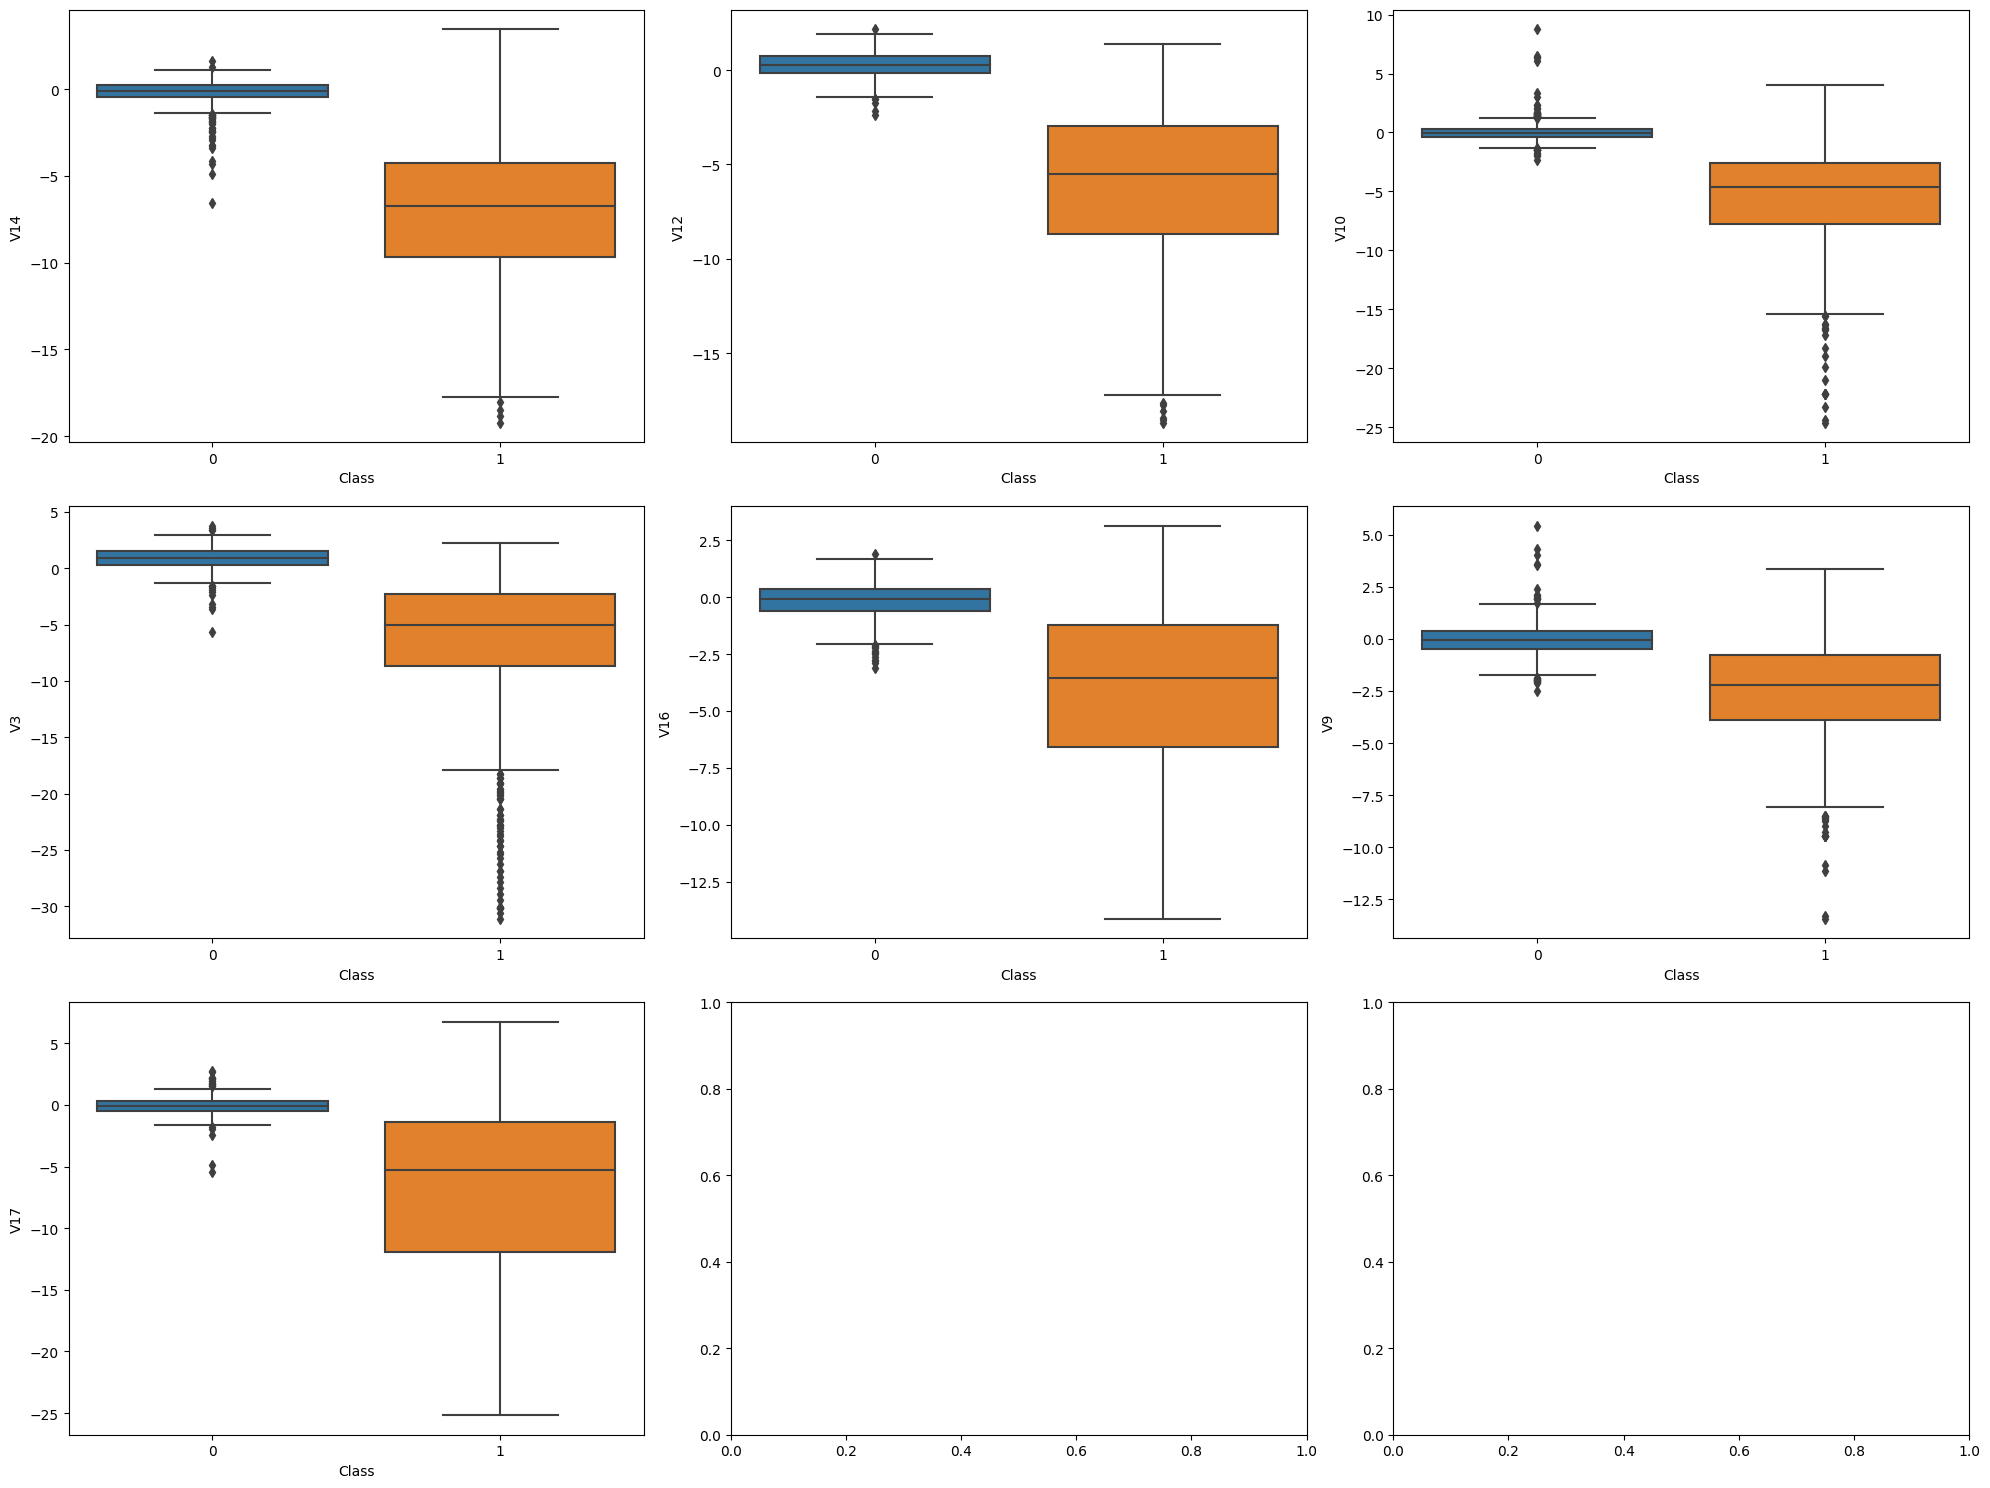

In [23]:
f, axes = plt.subplots(ncols=3, nrows = 3, figsize=(20,15))


for i,n in enumerate(neg_corr):
    sns.boxplot(x = 'Class', y = n , data = new_df,ax=axes[i//3, i%3])
    
plt.tight_layout()
plt.show()

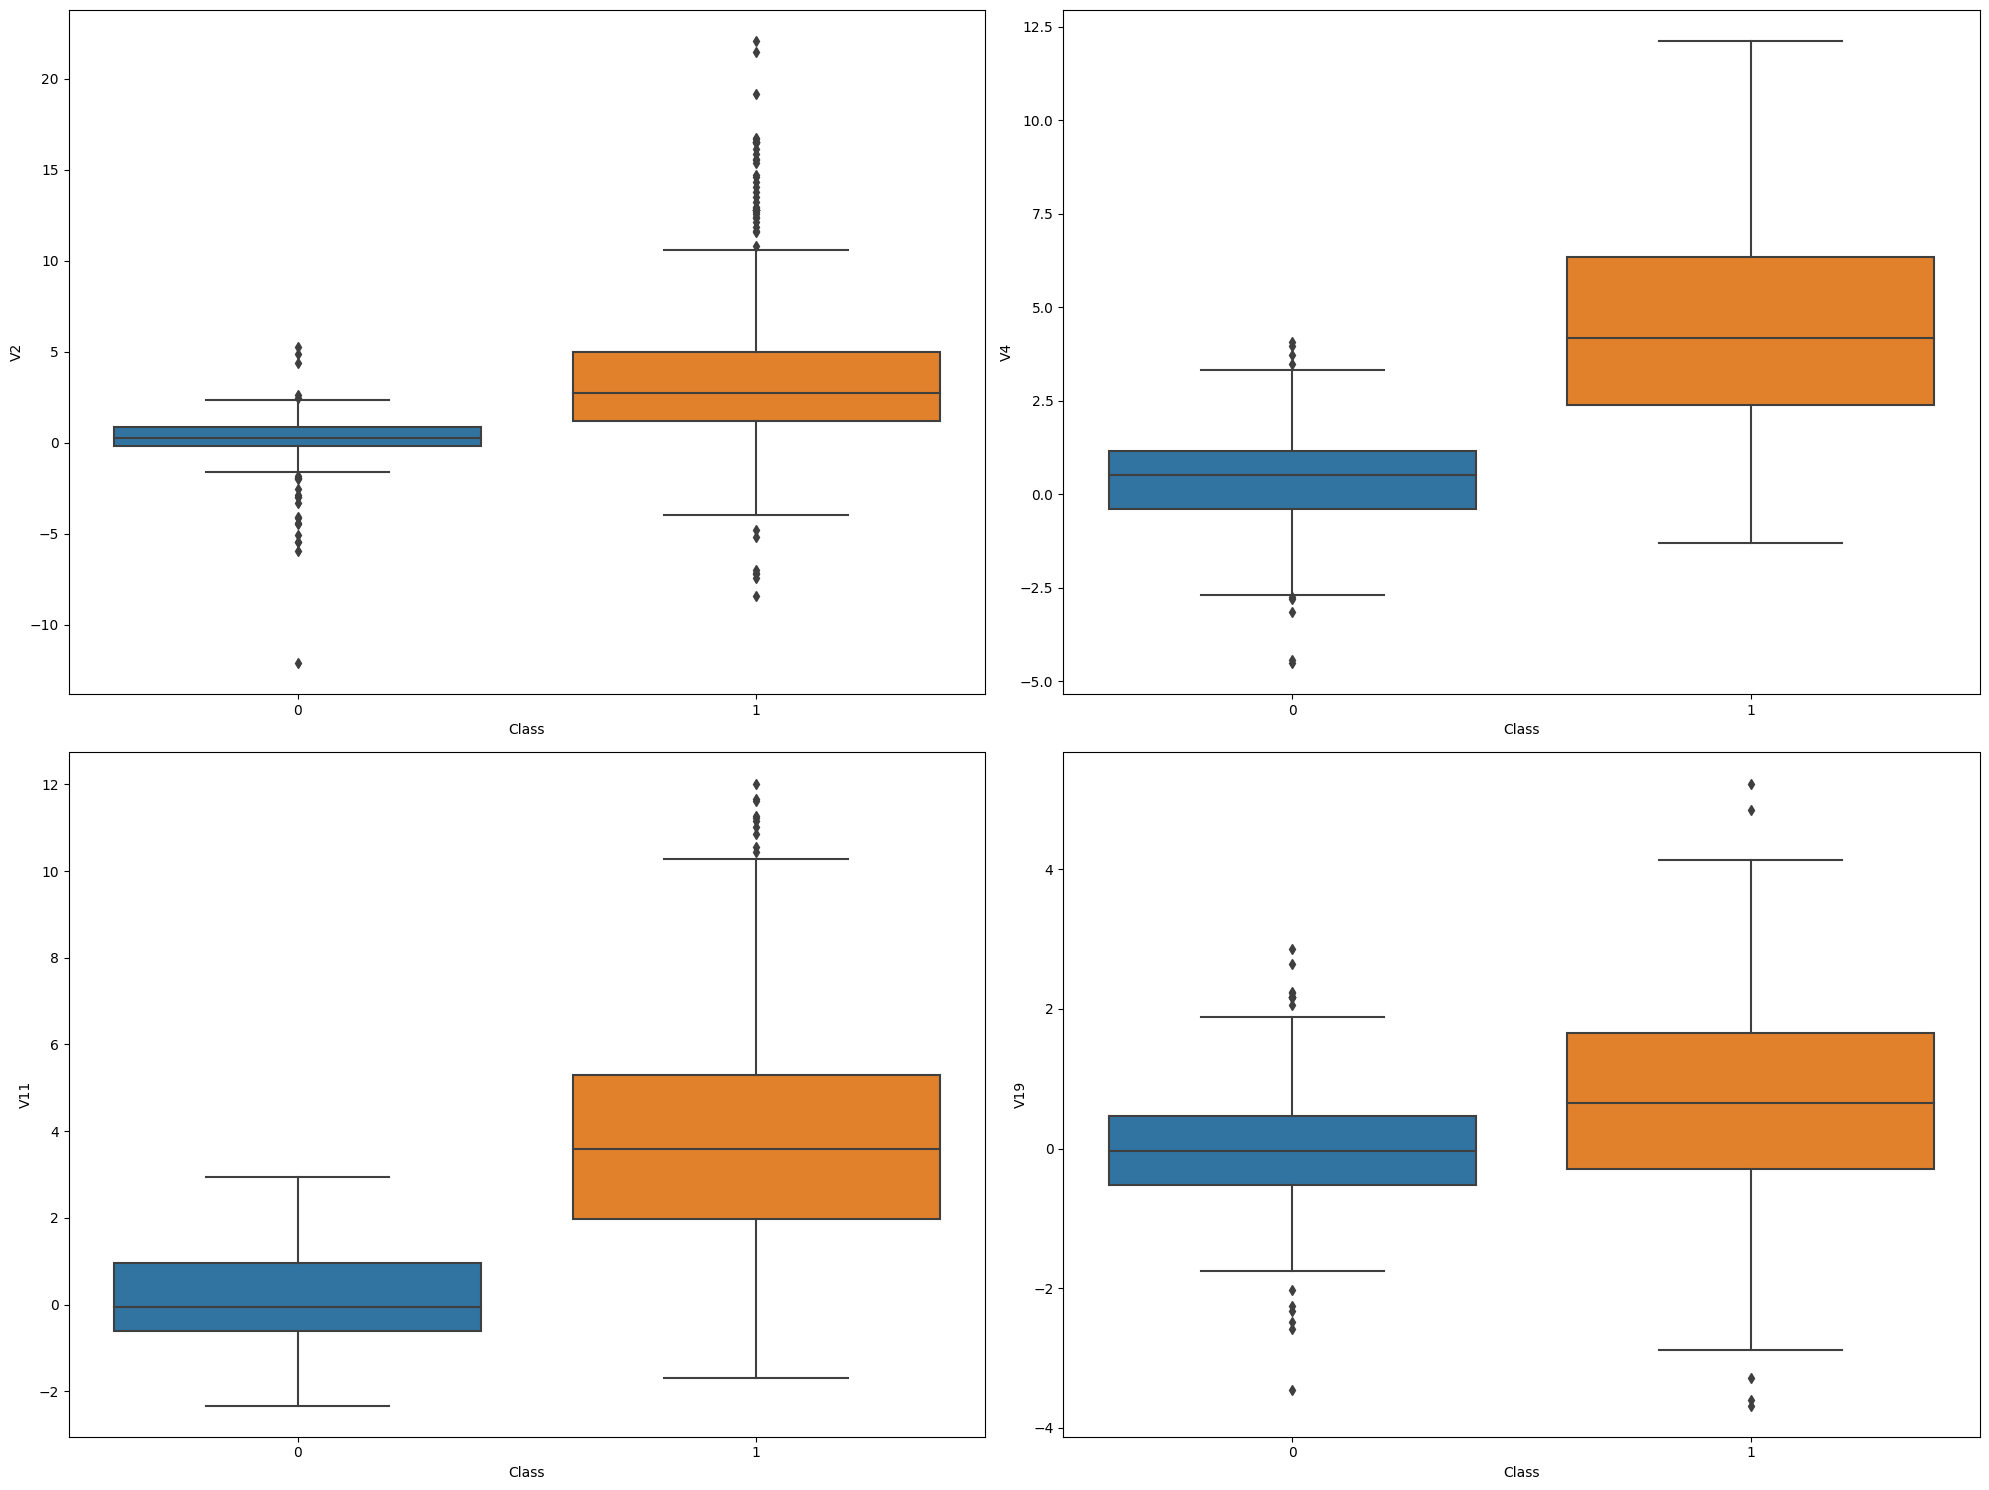

In [24]:
f, axes = plt.subplots(ncols=2, nrows = 2, figsize=(20,15))


for i,n in enumerate(pos_corr):
    sns.boxplot(x = 'Class', y = n , data = new_df,ax=axes[i//2, i%2])
    
plt.tight_layout()
plt.show()

All these features have a lot of outliers. Its better to get rid of these so that our model has good accuracy.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

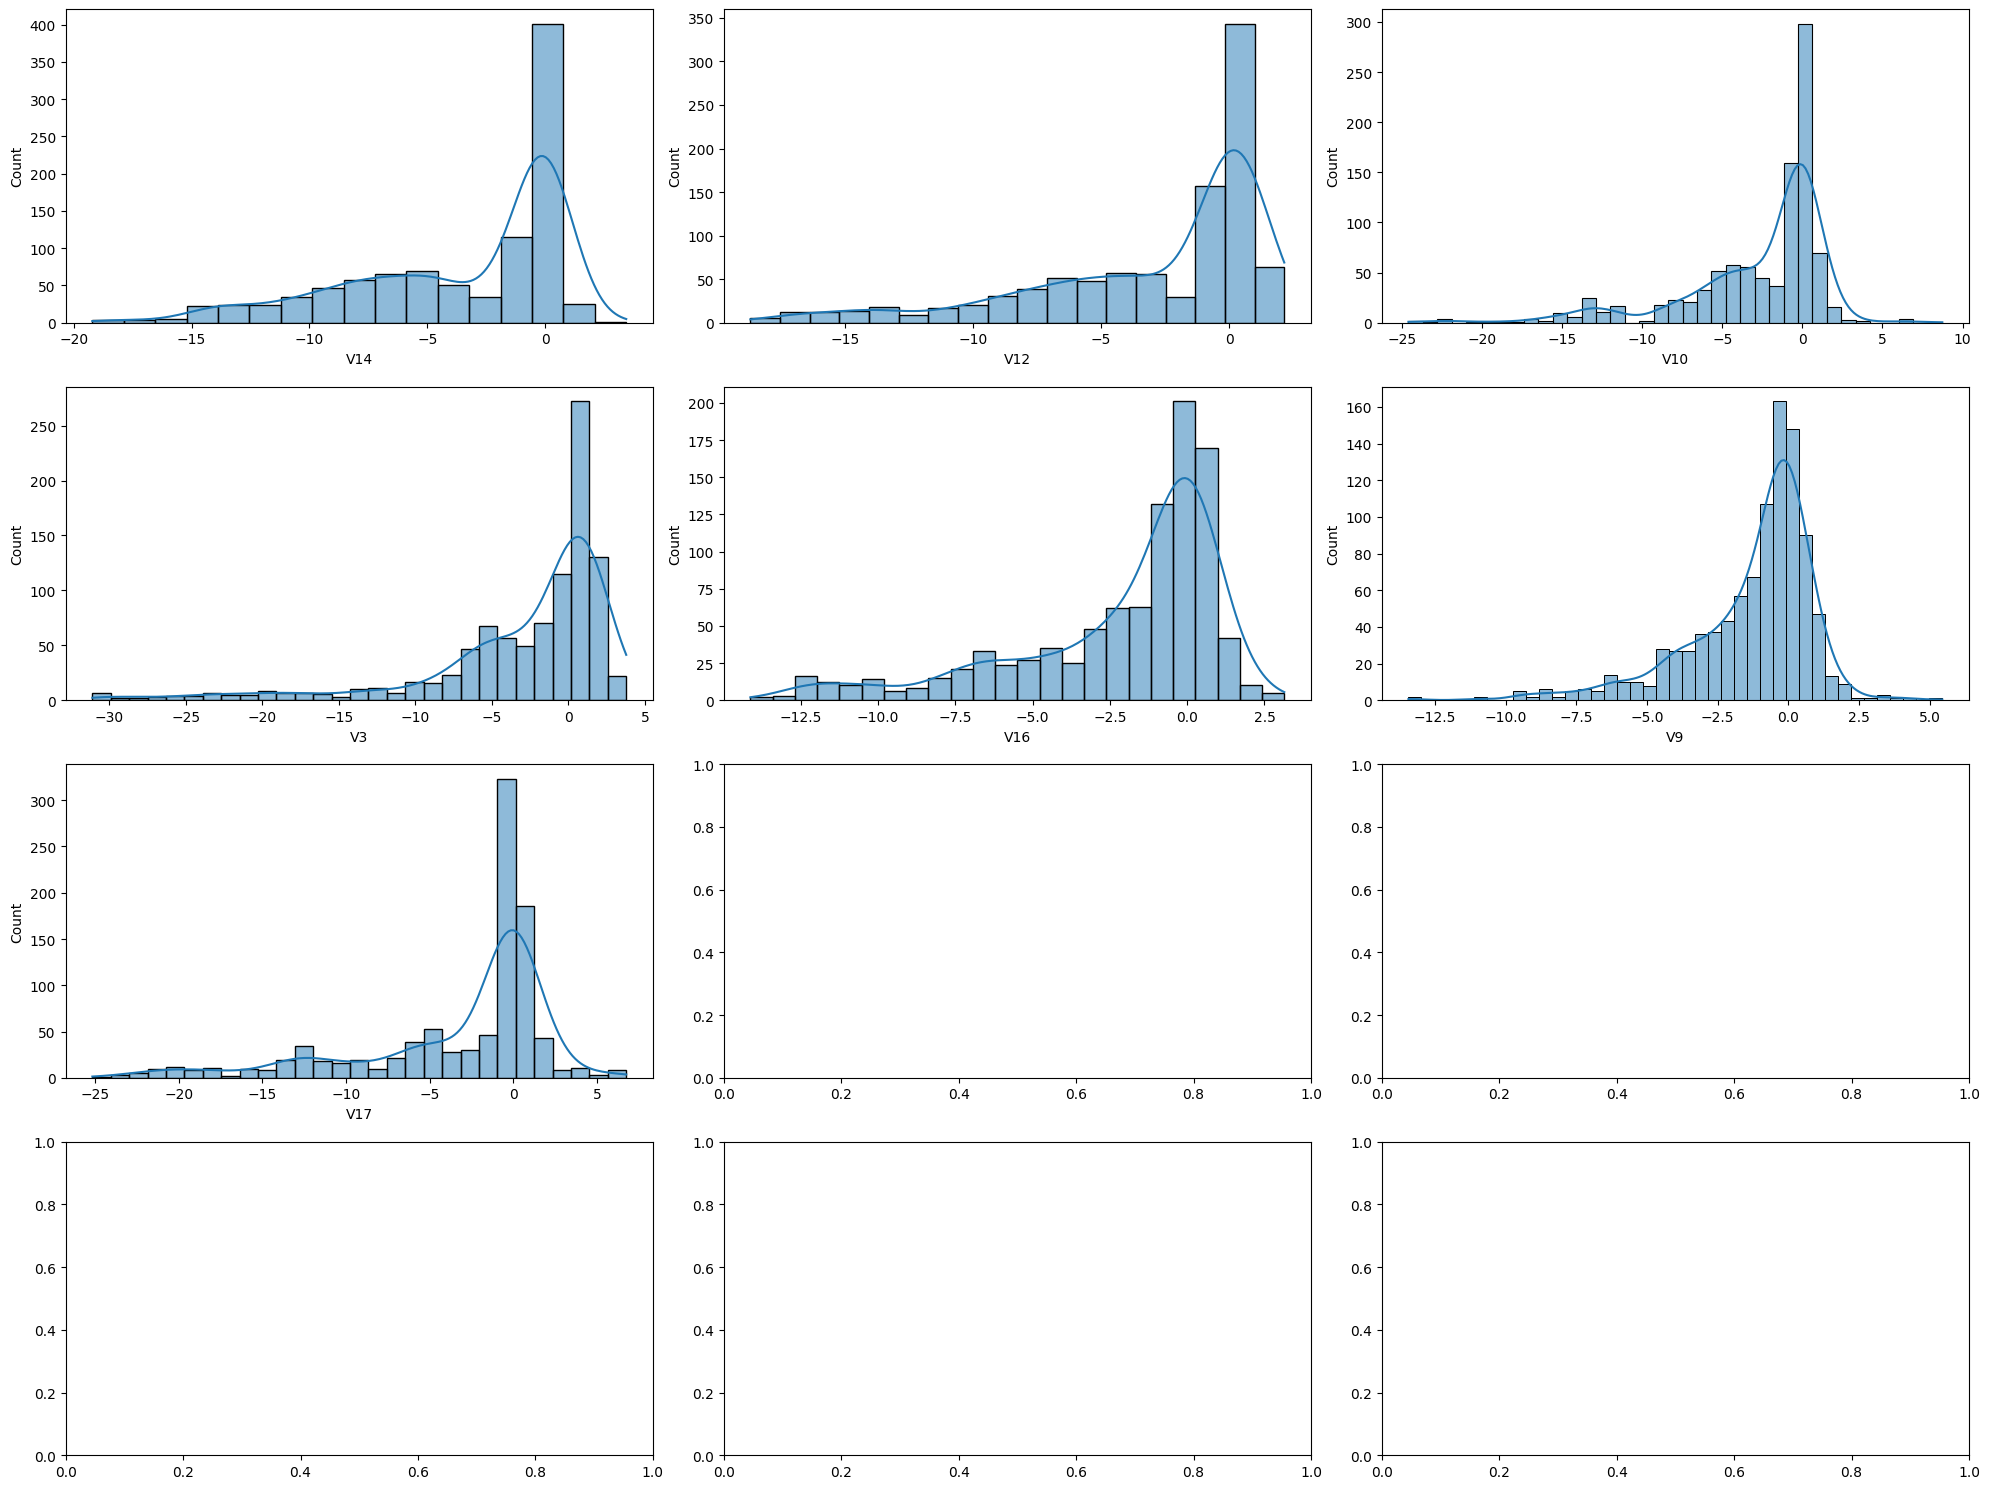

In [25]:
f, axes = plt.subplots(ncols=3, nrows = 4, figsize=(20,15))


for i,n in enumerate(neg_corr):
    sns.histplot(x = n , data = new_df,ax=axes[i//3, i%3],kde = True)
    
plt.tight_layout()
plt.show()

Most of these features are left skewed except v6 which sort of seems to be normally distributed.
While removing outliers, we need to be careful as to not remove a lot of information. We need to target extreme outliers. The outlier removal technique that we can use is IQR.

In [26]:
def remove_outliers_iqr(data, col, threshold=1.5):
    q1 = np.percentile(data[col], 25)
    q3 = np.percentile(data[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    #print('Lower bound: ', lower_bound)
    #print('Upper bound: ', upper_bound)
    #outliers_removed = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    outliers_removed = data.drop(data[(data[col] < lower_bound) | (data[col] > upper_bound)].index)
    #print(outliers_removed.shape)
    return outliers_removed

In [27]:
for col in neg_corr:
    clean_data = remove_outliers_iqr(new_df, col,1.5)
   

In [28]:
for col in pos_corr:
    clean_data = remove_outliers_iqr(new_df, col,1.5)
   

In [29]:
print(f'New df size {new_df.shape} and clean data size {clean_data.shape}')

New df size (984, 31) and clean data size (951, 31)


Now that we have removed outliers, we will go ahead with dimensionality reduction before training the model. We will use t-SNE, PCA, and truncatedSVD.

In [30]:
X = clean_data.drop(columns = ['Class'])
y = clean_data['Class']

X_tsne = TSNE(n_components = 2,random_state = 42).fit_transform(X)
X_PCA = PCA(n_components = 2,random_state = 42).fit_transform(X)
X_SVD = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)

Text(0.5, 1.0, 'Truncated SVD')

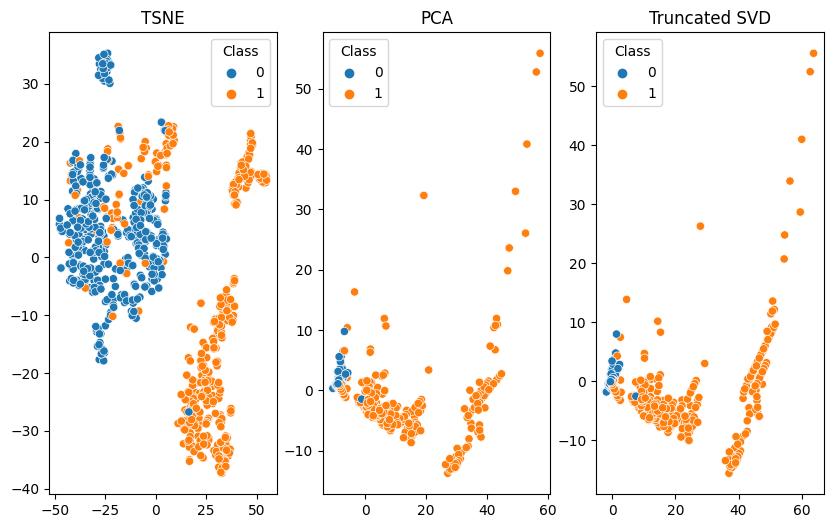

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,6))

sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], hue = y, ax = ax1)
ax1.set_title('TSNE')

sns.scatterplot(x = X_PCA[:,0], y = X_PCA[:,1], hue = y, ax = ax2)
ax2.set_title('PCA')

sns.scatterplot(x = X_SVD[:,0], y = X_SVD[:,1], hue = y, ax = ax3)
ax3.set_title('Truncated SVD')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [33]:
classifiers = {
    'Logistic Regression' : LogisticRegression(),
    'SVC' : SVC(),
    'Decision Tree Classifier' : DecisionTreeClassifier(),
    'KNearest' : KNeighborsClassifier(),
    'Random Forest Classifier' : RandomForestClassifier()
}

In [34]:
from sklearn.model_selection import cross_val_score

for key,classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    train_score = cross_val_score(classifier, X_train, y_train, cv = 5)
    print(f'{key} has a score of {round(train_score.mean(),2) * 100} accuracy')
    

Logistic Regression has a score of 99.0 accuracy
SVC has a score of 96.0 accuracy
Decision Tree Classifier has a score of 100.0 accuracy
KNearest has a score of 95.0 accuracy
Random Forest Classifier has a score of 100.0 accuracy


Let suse GridSearch to see what the best params for these classifiers are.

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
log_reg_params = {'penalty' : ['l1', 'l2'] , 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

knears_params = {'n_neighbors' : list(range(2,6,1)), 'algorithm' : ['auto', 'brute', 'kd_tree']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears = grid_knears.best_estimator_

svc_params = {'C' : [0.1, 1, 0.5, 0.9 ], 'kernel' : ['rbf', 'linear', 'poly']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree = grid_tree.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [37]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  99.87%
Knears Neighbors Cross Validation Score 95.39%
Support Vector Classifier Cross Validation Score 99.87%
DecisionTree Classifier Cross Validation Score 100.0%


Plotting learning curves to understand if they're overfitting

In [38]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

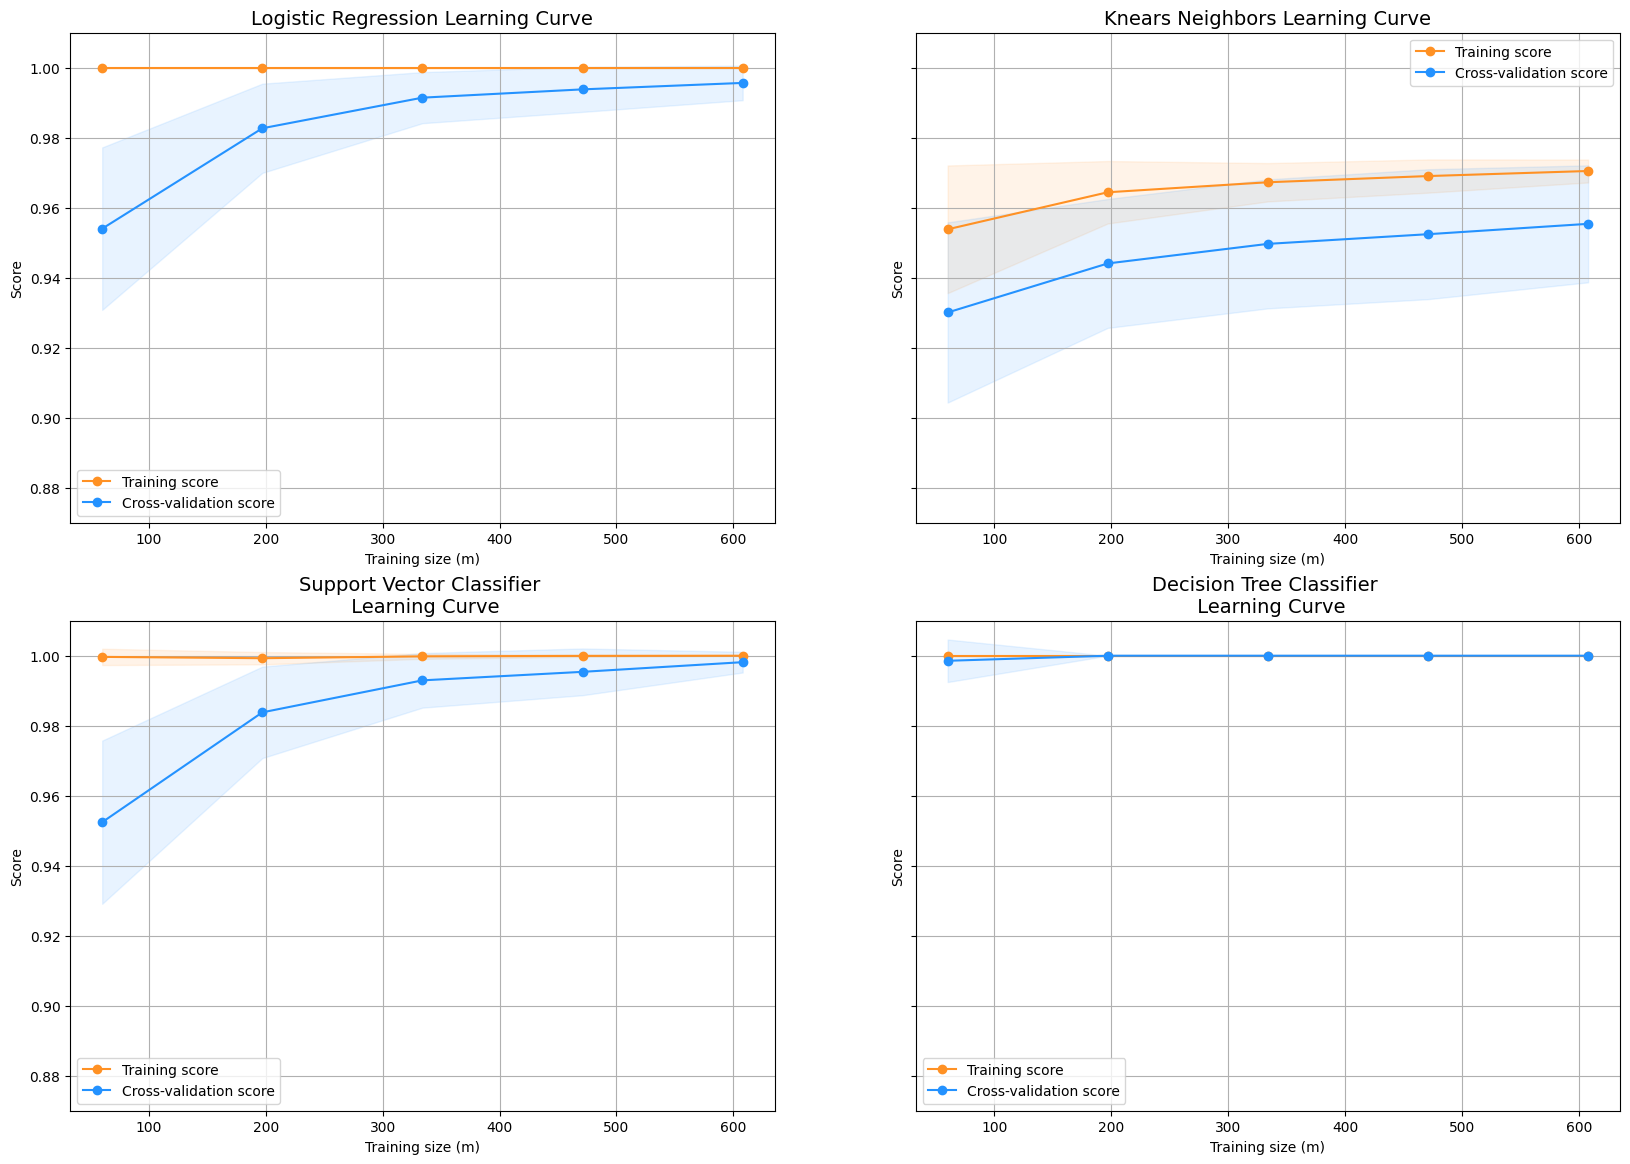

In [39]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears, svc, tree, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [40]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
#log_reg, knears, svc, tree

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree, X_train, y_train, cv=5)


As you can see, its pretty evident that the models are underfitting. Lets try with oversampling the minority class this time using SMOTE.

In [41]:
y_pred = grid_log_reg.predict(X_test)

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        98
           1       1.00      0.98      0.99        93

    accuracy                           0.99       191
   macro avg       0.99      0.99      0.99       191
weighted avg       0.99      0.99      0.99       191



In [43]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## Logistic Regression with RandomizedSearchCV

In [44]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

print('Length of X(train): {} | Length of y(train): {}'.format(len(original_X_Train), len(original_y_Train)))
print('Length of X(train): {} | Length of y(train): {}'.format(len(original_X_Test), len(original_y_Test)))


accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_sm = LogisticRegression(penalty='l2')

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter = 4)

for train,test in sss.split(original_X_Train,original_y_Train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) #this ensures that oversampling happens during cross validation and not before
    model = pipeline.fit(original_X_Train.iloc[train], original_y_Train.iloc[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_X_Train.iloc[test])
    accuracy_lst.append(pipeline.score(original_X_Train.iloc[test],  original_y_Train.iloc[test]))
    precision_lst.append(precision_score(original_y_Train.iloc[test], prediction))
    recall_lst.append(recall_score(original_y_Train.iloc[test], prediction))
    f1_lst.append(f1_score(original_y_Train.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_y_Train.iloc[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X(train): 227846 | Length of y(train): 227846
Length of X(train): 56961 | Length of y(train): 56961


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9390516561676456
precision: 0.061001858086166004
recall: 0.9162934112301201
f1: 0.11260385408331093
---------------------------------------------------------------------------------------------------------------------------------------


In [45]:
labels = ['No Fraud', 'Fraud']
smote_pred = best_est.predict(original_X_Test)
print(classification_report(original_y_Test,smote_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.11      0.85      0.19        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



As you can see the precision is very small and that makes sense this is an imbalanced data set with non-fraud cases being the majority. Hence looking at the precision in this case is not right.

F1 score is also low since it is influenced by the very low precision. The correct score to look at is recall. Recall is a measure of the ability of a model to correctly identify all relevant instances of a particular class. This model was able to correctly classify 85% of fraud cases correctly and 99% of non-fraud cases correctly.
This oversampled model is actually doing well interms of correctly classifying the fraud cases 85% of the time considering we tested on the actual test split from the originally imbalanced data.

Since this is an imbalanced dataset, boosting algorithms like XGBoost or AdaBoost will perform well since more weight will be assigned to minority class while learning.

In [46]:
import xgboost as xgb

sm_xgb = xgb.XGBClassifier()
xgb_params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

rand_xgb = RandomizedSearchCV(sm_xgb, xgb_params, n_iter = 4)

for train,test in sss.split(original_X_Train,original_y_Train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) #this ensures that oversampling happens during cross validation and not before
    model = pipeline.fit(original_X_Train.iloc[train], original_y_Train.iloc[train])
    best_est = rand_xgb.best_estimator_
    prediction = best_est.predict(original_X_Train.iloc[test])
    accuracy_lst.append(pipeline.score(original_X_Train.iloc[test],  original_y_Train.iloc[test]))
    precision_lst.append(precision_score(original_y_Train.iloc[test], prediction))
    recall_lst.append(recall_score(original_y_Train.iloc[test], prediction))
    f1_lst.append(f1_score(original_y_Train.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_y_Train.iloc[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

smote_pred_xgb = best_est.predict(original_X_Test)
print('Classification Report for XGB: ', classification_report(original_y_Test,smote_pred_xgb)) 


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9850512507990727
precision: 0.4443697596546138
recall: 0.8352158390133073
f1: 0.4730287332275325
---------------------------------------------------------------------------------------------------------------------------------------
Classification Report for XGB:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.62      0.75        98

    accuracy                           1.00     56961
   macro avg       0.97      0.81      0.87     56961
weighted avg       1.00      1.00      1.00     56961



XGboost did not do as well as Logistic Regression looking at the recall rate. It was only able to correctly recognize 62% of the fraud cases correctly.


## AdaBoost

In [47]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

sm_ada = AdaBoostClassifier(n_estimators = 400, learning_rate = 1)
for train,test in sss.split(original_X_Train,original_y_Train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), sm_ada)
    model = pipeline.fit(original_X_Train.iloc[train], original_y_Train.iloc[train])
    prediction = model.predict(original_X_Train.iloc[test])
    accuracy_lst.append(pipeline.score(original_X_Train.iloc[test],  original_y_Train.iloc[test]))
    precision_lst.append(precision_score(original_y_Train.iloc[test], prediction))
    recall_lst.append(recall_score(original_y_Train.iloc[test], prediction))
    f1_lst.append(f1_score(original_y_Train.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_y_Train.iloc[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

smote_pred_ada = model.predict(original_X_Test)
print('Classification Report for AdaBoost: ', classification_report(original_y_Test,smote_pred_ada))

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.7830619196233645
precision: 0.21319849859864273
recall: 0.8327815644271341
f1: 0.16651590807640393
---------------------------------------------------------------------------------------------------------------------------------------
Classification Report for AdaBoost:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.49      0.65        98

    accuracy                           1.00     56961
   macro avg       0.99      0.74      0.83     56961
weighted avg       1.00      1.00      1.00     56961



In [48]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

Xsm_train, ysm_train = sm.fit_resample(original_X_Train, original_y_Train)

In [49]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
oversample_model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 4s - 3ms/step - accuracy: 0.9739 - loss: 0.0769 - val_accuracy: 0.9946 - val_loss: 0.0253
Epoch 2/20
1214/1214 - 2s - 2ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9994 - val_loss: 0.0097
Epoch 3/20
1214/1214 - 3s - 2ms/step - accuracy: 0.9983 - loss: 0.0080 - val_accuracy: 0.9997 - val_loss: 0.0039
Epoch 4/20
1214/1214 - 2s - 2ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/20
1214/1214 - 2s - 2ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 6/20
1214/1214 - 2s - 2ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 7/20
1214/1214 - 2s - 2ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 8/20
1214/1214 - 3s - 2ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 8.0325e-04
Epoch 9/20
1214/1214 - 2s - 2ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 1.000

In [52]:
oversample_predictions = oversample_model.predict(original_X_Test, batch_size=200, verbose=0)
oversample_fraud_predictions = oversample_model.predict(original_X_Test, batch_size=200, verbose=0)
oversample_fraud_predictions = np.argmax(oversample_fraud_predictions, axis=1)

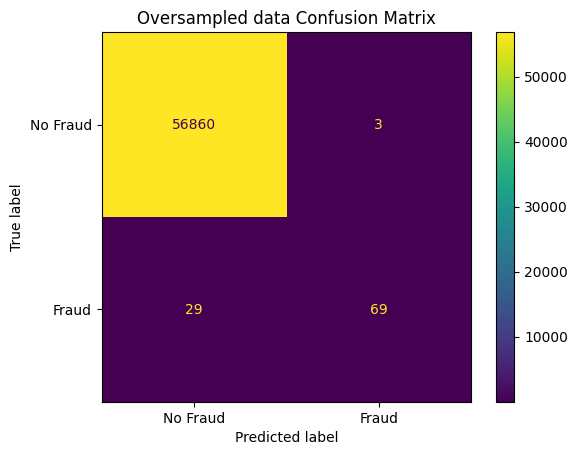

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics


oversample_smote = confusion_matrix(original_y_Test, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_y_Test, original_y_Test)
labels = ['No Fraud', 'Fraud']

#fig = plt.figure(figsize=(16,8))

#fig.add_subplot(221)
#plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

#fig.add_subplot(222)
#plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)


#confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = oversample_smote, display_labels = labels)

cm_display.plot()
plt.title('Oversampled data Confusion Matrix')
plt.show()

In [54]:
undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 1s - 49ms/step - accuracy: 0.6480 - loss: 0.5204 - val_accuracy: 0.8553 - val_loss: 0.4521
Epoch 2/20
25/25 - 0s - 5ms/step - accuracy: 0.9342 - loss: 0.3084 - val_accuracy: 0.9013 - val_loss: 0.2917
Epoch 3/20
25/25 - 0s - 6ms/step - accuracy: 0.9572 - loss: 0.1954 - val_accuracy: 0.9013 - val_loss: 0.2149
Epoch 4/20
25/25 - 0s - 5ms/step - accuracy: 0.9638 - loss: 0.1362 - val_accuracy: 0.9013 - val_loss: 0.1733
Epoch 5/20
25/25 - 0s - 3ms/step - accuracy: 0.9704 - loss: 0.1015 - val_accuracy: 0.9145 - val_loss: 0.1515
Epoch 6/20
25/25 - 0s - 6ms/step - accuracy: 0.9737 - loss: 0.0824 - val_accuracy: 0.9342 - val_loss: 0.1368
Epoch 7/20
25/25 - 0s - 4ms/step - accuracy: 0.9753 - loss: 0.0679 - val_accuracy: 0.9342 - val_loss: 0.1296
Epoch 8/20
25/25 - 0s - 6ms/step - accuracy: 0.9770 - loss: 0.0597 - val_accuracy: 0.9408 - val_loss: 0.1171
Epoch 9/20
25/25 - 0s - 6ms/step - accuracy: 0.9786 - loss: 0.0517 - val_accuracy: 0.9408 - val_loss: 0.1111
Epoch 10/20
25/25 

In [56]:
#undersample_predictions = undersample_model.predict(original_X_Test, batch_size=200, verbose=0)

undersample_predictions = undersample_model.predict(original_X_Test, batch_size=200, verbose=0)
undersample_predictions = np.argmax(undersample_predictions, axis=1)

In [57]:
undersample_predictions

array([1, 1, 1, ..., 1, 1, 1])

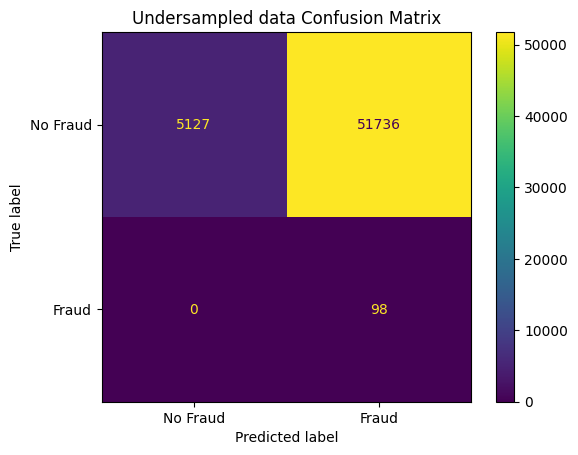

In [58]:
undersample_model_cm = confusion_matrix(original_y_Test, undersample_predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = undersample_model_cm, display_labels = labels)

cm_display.plot()
plt.title('Undersampled data Confusion Matrix')
plt.show()

Surpirsingly undersampled data has performed really well on undersampled data. Classifying all 98 instances of fraud cases as fraud with 0 misclassifications

## Conclusion

For the classifiers tried earlier, oversampling the data and feeding it to a Logistic Regression algorithm got us a good recall score menaing the model could accurately classify fraud transactions and non-fraud transactions.When the same oversampled and undersampel data were fed to neural network, the oversampled data did much better than undersampled data. The undersampled data incorrectly classified non-fraud transactions as well.

